# DNN using Heart stroke data 

This work is aiming at the design and testing of a deep neural network architecture on Heart attack(1), Congestive heart disease(2), Coronary heart disease(3), and Stroke(4) using Tensorflow and Keras.

In [121]:
import numpy as np
import copy
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import seed
np.random.seed(2095)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [122]:
# read input file
file = '/Users/devil/Dropbox/CardiacPrediction.xlsx'
ipData = pd.read_excel(file, sheet_name='CoroHeartDis')
print(ipData.columns) 

Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke', 'CoronaryHeartDisease'],
      dtype='object')


In [123]:
# data drop
opLabel = np.array(ipData['CoronaryHeartDisease'])
ipData.drop(['SEQN','CoronaryHeartDisease','Annual-Family-Income','Height','Ratio-Family-Income-Poverty',
             'X60-sec-pulse','Health-Insurance','Lymphocyte','Monocyte','Eosinophils','Total-Cholesterol',
             'Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)

In [124]:
# dummy variable for categorical variables
ipData = pd.get_dummies(ipData,columns=["Gender","Diabetes","Blood-Rel-Diabetes","Blood-Rel-Stroke","Vigorous-work","Moderate-work"]) 

varb = np.array(ipData.columns)
ipData = np.array(ipData)

In [125]:
print(ipData.shape)
print(varb)
print(len(opLabel[opLabel==0]))
print(len(opLabel[opLabel==1]))

(37079, 54)
['Age' 'Systolic' 'Diastolic' 'Weight' 'Body-Mass-Index'
 'White-Blood-Cells' 'Basophils' 'Red-Blood-Cells' 'Hemoglobin'
 'Mean-cell-Hemoglobin' 'Platelet-count' 'Mean-Platelet-Vol'
 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST' 'ALT' 'Cholesterol'
 'Creatinine' 'Glucose' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin'
 'Protein' 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1'
 'Gender_2' 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Diabetes_9'
 'Blood-Rel-Diabetes_1' 'Blood-Rel-Diabetes_2' 'Blood-Rel-Diabetes_7'
 'Blood-Rel-Diabetes_9' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Blood-Rel-Stroke_7' 'Blood-Rel-Stroke_9' 'Vigorous-work_1'
 'Vigorous-work_2' 'Vigorous-work_3' 'Vigorous-work_7' 'Vigorous-work_9'
 'Moderate-work_1' 'Moderate-work_2' 'Moderate-work_3' 'Moderate-work_7'
 'Moderate-work_9']
35571
1508


In [126]:
#Data condensation using LASSO penalty
from sklearn.linear_model import Lasso, LogisticRegression


featureVote = np.zeros(ipData.shape[1])
print(featureVote.shape)

iteR = 100

for num in range(iteR):
    label0_indx = np.where(opLabel==0)[0]   #no cardiac arrest
    label1_indx = np.where(opLabel==1)[0]   #cardiac arrest 
    numTrainData0 = 1500
    numTrainData1 = 1300
    np.random.shuffle(label0_indx)
    np.random.shuffle(label1_indx)
    
    label0_indx_train = label0_indx[0:numTrainData0-1]
    label1_indx_train = label1_indx[0:numTrainData1-1]
    label0_indx_test  = label0_indx[numTrainData0-1:]
    label1_indx_test  = label1_indx[numTrainData1-1:]
    
    testIndx  = np.append(label0_indx_test,label1_indx_test)
    trainIndx = np.append(label0_indx_train,label1_indx_train)    
    trainData  =  ipData[trainIndx]
    trainLabel =  opLabel[trainIndx]
    testData   =  ipData[testIndx]
    testLabel  =  opLabel[testIndx]    
    
    ##%% data standardization
    scaler = preprocessing.StandardScaler().fit(trainData)
    trainData_scaled = scaler.transform(trainData)
    testData_scaled  = scaler.transform(testData)
    
    ##%% Elastic net and Lasso from scikit
    #regr = ElasticNet(random_state=0, alpha=1, l1_ratio=0.03, tol=0.000001, max_iter=100000)
    regr = Lasso(random_state=0, alpha=0.006, tol=0.000001, max_iter=100000)
    #regr = LogisticRegression(penalty='l1',random_state=0,C=100,tol=0.000001,max_iter=100,class_weight='balanced')
    regr.fit(trainData_scaled,trainLabel)
    cof = np.abs(regr.coef_)    
    colIndx = np.where(cof != 0)[0]
    for col in colIndx:
        featureVote[col]+=1

(54,)


In [127]:
print(featureVote)

[100.  35.  89.  33.  12.  91.  51.  76.   5.  17. 100.  47. 100.  46.
  33.  22.   9. 100.  90.  15.  36.  30. 100.  24.  40.  26. 100.  99.
  98.  98. 100.  49.  86.  81.   7.  75.  58.  40.  13.  23.  98.  89.
  14.   1.  15.   9.  88.   6.   3.   2.  97.  62.   6.   7.]


In [128]:
# feature nomination via Lasso (from feature 1 to 35)
# We keep the dummy variables

featureIndx = np.where(featureVote[0:30]>=iteR//6)[0]
featureIndx = np.append(featureIndx, np.arange(30,ipData.shape[1]))
print(varb[featureIndx])

['Age' 'Systolic' 'Diastolic' 'Weight' 'White-Blood-Cells' 'Basophils'
 'Red-Blood-Cells' 'Mean-cell-Hemoglobin' 'Platelet-count'
 'Mean-Platelet-Vol' 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST'
 'Cholesterol' 'Creatinine' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin'
 'Protein' 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1'
 'Gender_2' 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Diabetes_9'
 'Blood-Rel-Diabetes_1' 'Blood-Rel-Diabetes_2' 'Blood-Rel-Diabetes_7'
 'Blood-Rel-Diabetes_9' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Blood-Rel-Stroke_7' 'Blood-Rel-Stroke_9' 'Vigorous-work_1'
 'Vigorous-work_2' 'Vigorous-work_3' 'Vigorous-work_7' 'Vigorous-work_9'
 'Moderate-work_1' 'Moderate-work_2' 'Moderate-work_3' 'Moderate-work_7'
 'Moderate-work_9']


In [129]:
featureIndx.shape

(50,)

# Dataset reduction (Re-run every time you change the number of training data)

In [130]:
reduced_data = ipData[:,featureIndx]

label0_indx = np.where(opLabel==0)[0]   #no cardiac arrest
label1_indx = np.where(opLabel==1)[0]   #cardiac arrest 
numTrainData0 = 1500
numTrainData1 = 1300
np.random.shuffle(label0_indx)
np.random.shuffle(label1_indx)

label0_indx_train = label0_indx[0:numTrainData0]
label1_indx_train = label1_indx[0:numTrainData1]
label0_indx_test  = label0_indx[numTrainData0:]
label1_indx_test  = label1_indx[numTrainData1:]

testIndx  = np.append(label0_indx_test,label1_indx_test)
trainIndx = np.append(label0_indx_train,label1_indx_train)    
x_train  =  reduced_data[trainIndx]
y_train  =  opLabel[trainIndx]
x_test   =  reduced_data[testIndx]
y_test   =  opLabel[testIndx]    

In [131]:
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

In [132]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [133]:
#%% one-hot-encoding
y_train = keras.utils.to_categorical(y_train,2)
y_test  = keras.utils.to_categorical(y_test,2)

In [134]:
y_train.shape

(2800, 2)

# Running the part above is MANDATORY for training any Network below

## MLP only

In [16]:
# MLP -2
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

FC1    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(DP0)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
DP1    = keras.layers.Dropout(0.2)(AC1)


FC2 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(DP1)
outputs = keras.layers.Activation('softmax')(FC2)

myMLP = keras.Model(inputs=inputs,outputs=outputs)
myMLP.compile(optimizer=keras.optimizers.Adam(lr=0.01),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myMLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26112     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
__________

In [17]:
class_weight = {0: 1, 1: 10}

myMLP.fit(x_train,y_train,epochs=50,batch_size=500,verbose=1, class_weight=class_weight)

Epoch 1/50
5300/5300 [==============================] - 1s 241us/step - loss: 2.0520 - acc: 0.5638
Epoch 2/50
5300/5300 [==============================] - 0s 28us/step - loss: 1.3106 - acc: 0.7134
Epoch 3/50
5300/5300 [==============================] - 0s 27us/step - loss: 1.1359 - acc: 0.6625
Epoch 4/50
5300/5300 [==============================] - 0s 26us/step - loss: 1.0491 - acc: 0.6904
Epoch 5/50
5300/5300 [==============================] - 0s 28us/step - loss: 1.0230 - acc: 0.7013
Epoch 6/50
5300/5300 [==============================] - 0s 28us/step - loss: 0.9903 - acc: 0.7043
Epoch 7/50
5300/5300 [==============================] - 0s 27us/step - loss: 0.9640 - acc: 0.7177
Epoch 8/50
5300/5300 [==============================] - 0s 28us/step - loss: 0.9448 - acc: 0.7174
Epoch 9/50
5300/5300 [==============================] - 0s 28us/step - loss: 0.9177 - acc: 0.7160
Epoch 10/50
5300/5300 [==============================] - 0s 29us/step - loss: 0.8727 - acc: 0.7328
Epoch 11/50
5300/5

In [18]:
test_loss,test_acc = myMLP.evaluate(x_test,y_test)
print(test_acc)

31779/31779 [==============================] - 1s 32us/step
0.777022562069291


In [74]:
from sklearn import metrics
predlabel = myMLP.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[25518  5553]
 [    1     7]]


In [20]:
# MLP -3 :: Input => Hidden(64) => Hidden(128) => Hidden(256)
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

FC1    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(DP0)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
DP1    = keras.layers.Dropout(0.2)(AC1)

FC2    = keras.layers.Dense(256, bias_initializer=keras.initializers.VarianceScaling())(DP1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
#DP2    = keras.layers.Dropout(0.2)(AC2)


FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(AC2)
outputs = keras.layers.Activation('softmax')(FC3)

myMLP3 = keras.Model(inputs=inputs,outputs=outputs)
myMLP3.compile(optimizer=keras.optimizers.Adam(lr=0.01),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myMLP3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                3264      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
__________

In [21]:
class_weight = {0: 1, 1: 1}

myMLP3.fit(x_train,y_train,epochs=100,batch_size=3000,verbose=1, class_weight=class_weight)

Epoch 1/100
5300/5300 [==============================] - 1s 163us/step - loss: 0.6843 - acc: 0.7236
Epoch 2/100
5300/5300 [==============================] - 0s 17us/step - loss: 0.5704 - acc: 0.7806
Epoch 3/100
5300/5300 [==============================] - 0s 21us/step - loss: 0.5174 - acc: 0.7708
Epoch 4/100
5300/5300 [==============================] - 0s 20us/step - loss: 0.4331 - acc: 0.7981
Epoch 5/100
5300/5300 [==============================] - 0s 21us/step - loss: 0.4147 - acc: 0.7996
Epoch 6/100
5300/5300 [==============================] - 0s 19us/step - loss: 0.3979 - acc: 0.8051
Epoch 7/100
5300/5300 [==============================] - 0s 18us/step - loss: 0.3804 - acc: 0.8185
Epoch 8/100
5300/5300 [==============================] - 0s 18us/step - loss: 0.3808 - acc: 0.8236
Epoch 9/100
5300/5300 [==============================] - 0s 21us/step - loss: 0.3709 - acc: 0.8243
Epoch 10/100
5300/5300 [==============================] - 0s 18us/step - loss: 0.3727 - acc: 0.8191
Epoch 11

5300/5300 [==============================] - 0s 21us/step - loss: 0.1954 - acc: 0.9172
Epoch 84/100
5300/5300 [==============================] - 0s 25us/step - loss: 0.1964 - acc: 0.9174
Epoch 85/100
5300/5300 [==============================] - 0s 22us/step - loss: 0.1989 - acc: 0.9177
Epoch 86/100
5300/5300 [==============================] - 0s 20us/step - loss: 0.1917 - acc: 0.9200
Epoch 87/100
5300/5300 [==============================] - 0s 18us/step - loss: 0.1941 - acc: 0.9179
Epoch 88/100
5300/5300 [==============================] - 0s 19us/step - loss: 0.1893 - acc: 0.9162
Epoch 89/100
5300/5300 [==============================] - 0s 21us/step - loss: 0.1793 - acc: 0.9243
Epoch 90/100
5300/5300 [==============================] - 0s 24us/step - loss: 0.1915 - acc: 0.9223
Epoch 91/100
5300/5300 [==============================] - 0s 22us/step - loss: 0.1926 - acc: 0.9179
Epoch 92/100
5300/5300 [==============================] - 0s 19us/step - loss: 0.1828 - acc: 0.9177
Epoch 93/100


In [22]:
test_loss,test_acc = myMLP3.evaluate(x_test,y_test)
print(test_acc)

31779/31779 [==============================] - 1s 35us/step
0.931841782309072


In [23]:
from sklearn import metrics
predlabel = myMLP3.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[29535  2036]
 [  130    78]]


# Introducing convolutional layers

## MLP+Conv :: Input => Hidden(128)  => Conv(4) => Output (2)

In [24]:

inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((128,1))(DP0)
FC1    = keras.layers.Conv1D(4,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.MaxPool1D(pool_size=2)(AC1)
FL1   = keras.layers.Flatten()(Pool1)

FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(FL1)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D1 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D1.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D1.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               6528      
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
___________________________________________________________

In [25]:
class_weight = {0: 1, 1: 5}

myCNN1D1.fit(x_train,y_train,epochs=10,verbose=1, class_weight=class_weight)

Epoch 1/10
5300/5300 [==============================] - 2s 286us/step - loss: 1.1672 - acc: 0.6343
Epoch 2/10
5300/5300 [==============================] - 1s 138us/step - loss: 0.9489 - acc: 0.7117
Epoch 3/10
5300/5300 [==============================] - 1s 140us/step - loss: 0.9002 - acc: 0.7283
Epoch 4/10
5300/5300 [==============================] - 1s 141us/step - loss: 0.8568 - acc: 0.7394
Epoch 5/10
5300/5300 [==============================] - 1s 143us/step - loss: 0.8266 - acc: 0.7466
Epoch 6/10
5300/5300 [==============================] - 1s 185us/step - loss: 0.8190 - acc: 0.7475
Epoch 7/10
5300/5300 [==============================] - 1s 184us/step - loss: 0.7893 - acc: 0.7551
Epoch 8/10
5300/5300 [==============================] - 1s 160us/step - loss: 0.7889 - acc: 0.7585
Epoch 9/10
5300/5300 [==============================] - 1s 147us/step - loss: 0.7681 - acc: 0.7642
Epoch 10/10
5300/5300 [==============================] - 1s 148us/step - loss: 0.7725 - acc: 0.7636


In [26]:
test_loss,test_acc = myCNN1D1.evaluate(x_test,y_test)
print(test_acc)

31779/31779 [==============================] - 2s 54us/step
0.6637087384750936


In [27]:
from sklearn import metrics
predlabel = myCNN1D1.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[20910 10661]
 [   26   182]]


##  MLP+CONV: Input => Hidden(128)  => Conv(4) => Conv(8) => Output (2)

In [28]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((128,1))(DP0)
FC1    = keras.layers.Conv1D(4,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(8,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2 = keras.layers.AveragePooling1D(pool_size=2)(AC2)

FL1   = keras.layers.Flatten()(Pool2)

FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(FL1)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D2 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D2.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               6528      
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
activation_11 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 128, 1)            0         
__________

In [29]:
class_weight = {0: 1, 1: 10}

myCNN1D2.fit(x_train,y_train,epochs=50,verbose=1, class_weight=class_weight)

Epoch 1/50
5300/5300 [==============================] - 2s 354us/step - loss: 1.4510 - acc: 0.4683
Epoch 2/50
5300/5300 [==============================] - 1s 185us/step - loss: 1.2580 - acc: 0.6094
Epoch 3/50
5300/5300 [==============================] - 1s 187us/step - loss: 1.1706 - acc: 0.6406
Epoch 4/50
5300/5300 [==============================] - 1s 211us/step - loss: 1.1302 - acc: 0.6664
Epoch 5/50
5300/5300 [==============================] - 1s 202us/step - loss: 1.1023 - acc: 0.6632
Epoch 6/50
5300/5300 [==============================] - 1s 190us/step - loss: 1.0892 - acc: 0.6704
Epoch 7/50
5300/5300 [==============================] - 1s 211us/step - loss: 1.0451 - acc: 0.6849
Epoch 8/50
5300/5300 [==============================] - 1s 233us/step - loss: 1.0242 - acc: 0.6913
Epoch 9/50
5300/5300 [==============================] - 1s 190us/step - loss: 1.0205 - acc: 0.6947
Epoch 10/50
5300/5300 [==============================] - 1s 217us/step - loss: 1.0166 - acc: 0.6940
Epoch 11/

In [31]:
test_loss,test_acc = myCNN1D2.evaluate(x_test,y_test)
print(test_acc)

31779/31779 [==============================] - 2s 60us/step
0.7546807640265584


In [32]:
from sklearn import metrics
predlabel = myCNN1D2.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[23834  7737]
 [   59   149]]


## MLP+Conv :: Input => Hidden(64) => Conv(2) => Hidden(512)  

In [33]:

inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(32, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((32,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.MaxPool1D(pool_size=2)(AC1)
FL1   = keras.layers.Flatten()(Pool1)

FC2    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
#DP2    = keras.layers.Dropout(0.2)(AC2)


FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(AC2)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D3 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D3.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myCNN1D3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1632      
_________________________________________________________________
batch_normalization_11 (Batc (None, 32)                128       
_________________________________________________________________
activation_15 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 32, 1)             0         
__________

In [34]:
class_weight = {0: 1, 1: 4}

myCNN1D3.fit(x_train,y_train,epochs=50,verbose=1, class_weight=class_weight)

Epoch 1/50
5300/5300 [==============================] - 2s 286us/step - loss: 1.1021 - acc: 0.6398
Epoch 2/50
5300/5300 [==============================] - 1s 123us/step - loss: 0.9354 - acc: 0.6977
Epoch 3/50
5300/5300 [==============================] - 1s 120us/step - loss: 0.8824 - acc: 0.7174
Epoch 4/50
5300/5300 [==============================] - 1s 124us/step - loss: 0.8619 - acc: 0.7209
Epoch 5/50
5300/5300 [==============================] - 1s 127us/step - loss: 0.8278 - acc: 0.7330
Epoch 6/50
5300/5300 [==============================] - 1s 137us/step - loss: 0.8167 - acc: 0.7385
Epoch 7/50
5300/5300 [==============================] - 1s 139us/step - loss: 0.8024 - acc: 0.7413
Epoch 8/50
5300/5300 [==============================] - 1s 137us/step - loss: 0.7906 - acc: 0.7432
Epoch 9/50
5300/5300 [==============================] - 1s 130us/step - loss: 0.7867 - acc: 0.7434
Epoch 10/50
5300/5300 [==============================] - 1s 156us/step - loss: 0.7825 - acc: 0.7351
Epoch 11/

In [35]:
test_loss,test_acc = myCNN1D3.evaluate(x_test,y_test)
print(test_acc)

31779/31779 [==============================] - 1s 44us/step
0.7730891469209227


In [36]:
from sklearn import metrics
predlabel = myCNN1D3.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[24409  7162]
 [   49   159]]


## MLP+ CONV: Input => Dense(64) => Conv(2) => Conv(4) = Dense(512) => Dense (2) [Best]

In [135]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((64,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1  = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(4,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2  = keras.layers.AveragePooling1D(pool_size=2)(AC2)

FL1    = keras.layers.Flatten()(Pool2)

FC3    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
AC3    = keras.layers.Activation('relu')(BN3)
DP3    = keras.layers.Dropout(0.2)(AC3)


FC4    = keras.layers.Dense(2)(DP3)
outputs = keras.layers.Activation('softmax')(FC4)

myCNN1D4 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D4.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 50, 1)             0         
_________________________________________________________________
reshape_22 (Reshape)         (None, 50)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                3264      
_________________________________________________________________
batch_normalization_40 (Batc (None, 64)                256       
_________________________________________________________________
activation_52 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
reshape_23 (Reshape)         (None, 64, 1)             0         
__________

Epoch 1/50
2800/2800 [==============================] - 1s 184us/step - loss: 0.2758 - acc: 0.8861
Epoch 2/50
2800/2800 [==============================] - 0s 168us/step - loss: 0.2748 - acc: 0.8804
Epoch 3/50
2800/2800 [==============================] - 1s 209us/step - loss: 0.2723 - acc: 0.8879
Epoch 4/50
2800/2800 [==============================] - 1s 206us/step - loss: 0.2896 - acc: 0.8739
Epoch 5/50
2800/2800 [==============================] - 0s 174us/step - loss: 0.2706 - acc: 0.8896
Epoch 6/50
2800/2800 [==============================] - 0s 178us/step - loss: 0.2833 - acc: 0.8807
Epoch 7/50
2800/2800 [==============================] - 1s 213us/step - loss: 0.2720 - acc: 0.8836
Epoch 8/50
2800/2800 [==============================] - 1s 183us/step - loss: 0.2921 - acc: 0.8793
Epoch 9/50
2800/2800 [==============================] - 1s 180us/step - loss: 0.2847 - acc: 0.8821
Epoch 10/50
2800/2800 [==============================] - 0s 177us/step - loss: 0.2732 - acc: 0.8825
Epoch 11/

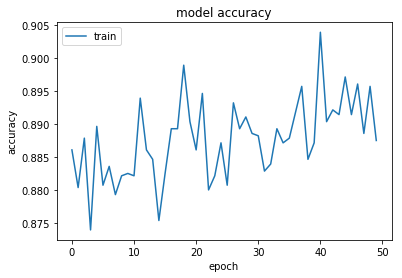

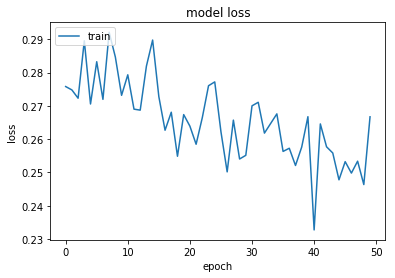

In [140]:
class_weight = {0: 1, 1: 1}

history = myCNN1D4.fit(x_train,y_train,epochs=50,verbose=1, class_weight=class_weight)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [141]:
test_loss,test_acc = myCNN1D4.evaluate(x_test,y_test)
print(test_acc)

34279/34279 [==============================] - 2s 64us/step
0.7116602001242628


Confusion Matrix:  24230 9841 43 165
Recall:  79.32692307692307
Precision:  1.6490105936438137
Specificity:  71.1161985266062
Type I error:  20.673076923076927
Type II error:  28.8838014733938
AUC:  75.22156080176462


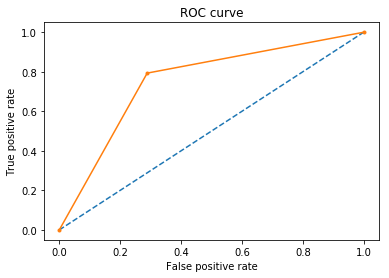

In [142]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
predlabel = myCNN1D4.predict(x_test)
f = np.argmax(predlabel,axis=1)
tn_test, fp_test, fn_test, tp_test = metrics.confusion_matrix(np.argmax(y_test,axis=1),f).flatten()

type_I_error_test = (1 - (tp_test/(tp_test+fn_test))) * 100
type_II_error_test = (1 - (tn_test/(tn_test+fp_test))) * 100

print("Confusion Matrix: ", tn_test, fp_test, fn_test, tp_test)
print("Recall: ", (tp_test/(tp_test+fn_test))*100)
print("Precision: ", (tp_test/(tp_test+fp_test))*100)
print("Specificity: ", (tn_test/(tn_test+fp_test))*100)
print("Type I error: ", type_I_error_test)
print("Type II error: ", type_II_error_test)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.argmax(y_test,axis=1),f)
from sklearn.metrics import auc
auc = auc(fpr_keras, tpr_keras)
print("AUC: ", auc*100)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_keras, tpr_keras, marker='.', label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
#plt.legend(loc='best')
# show the plot
plt.show()  

# The following section shows the result when 70% of data are used for training

In [41]:
# With train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(reduced_data, opLabel, test_size = 0.3, random_state = 24)

In [42]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [43]:
#%% one-hot-encoding
Y_train = keras.utils.to_categorical(Y_train,2)
Y_test  = keras.utils.to_categorical(Y_test,2)

In [44]:
# MLP -2
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

FC1    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(DP0)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
DP1    = keras.layers.Dropout(0.2)(AC1)


FC2 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(DP1)
outputs = keras.layers.Activation('softmax')(FC2)

myMLP = keras.Model(inputs=inputs,outputs=outputs)
myMLP.compile(optimizer=keras.optimizers.Adam(lr=0.01),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myMLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               26112     
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
_________________________________________________________________
activation_24 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               65664     
__________

In [45]:
np.where(Y_train==0)[0].shape
np.where(Y_train==1)[0].shape

(25955,)

In [46]:
class_weight = {0: 1, 1: 40}

myMLP.fit(X_train,Y_train,epochs=10,batch_size=1200,verbose=1, class_weight=class_weight)

Epoch 1/10
25955/25955 [==============================] - 2s 63us/step - loss: 1.4859 - acc: 0.6587
Epoch 2/10
25955/25955 [==============================] - 1s 23us/step - loss: 1.1220 - acc: 0.6680
Epoch 3/10
25955/25955 [==============================] - 1s 23us/step - loss: 1.0302 - acc: 0.6938
Epoch 4/10
25955/25955 [==============================] - 1s 24us/step - loss: 1.0092 - acc: 0.7024
Epoch 5/10
25955/25955 [==============================] - 1s 24us/step - loss: 0.9880 - acc: 0.6999
Epoch 6/10
25955/25955 [==============================] - 1s 30us/step - loss: 0.9397 - acc: 0.7081
Epoch 7/10
25955/25955 [==============================] - 1s 27us/step - loss: 0.9166 - acc: 0.7132
Epoch 8/10
25955/25955 [==============================] - 1s 30us/step - loss: 0.9124 - acc: 0.7246
Epoch 9/10
25955/25955 [==============================] - 1s 25us/step - loss: 0.8910 - acc: 0.7193
Epoch 10/10
25955/25955 [==============================] - 1s 30us/step - loss: 0.8475 - acc: 0.7383

In [47]:
test_loss,test_acc = myMLP.evaluate(X_test,Y_test)
print(test_acc)

11124/11124 [==============================] - 1s 63us/step
0.7381337648756596


In [48]:
from sklearn import metrics
predlabel = myMLP.predict(X_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(Y_test,axis=1),f)
print(confMat)

[[7847 2812]
 [ 101  364]]
